# Image Captioning - generating captions for images




### Steps
  - Data Collection
  - Understanding the data
  - Data Cleaning
  - Loading the training set
  - Data Preprocessing - Images
  - Data Preprocessing - Captions
  - Data Preparation using generator function
  - Word Embeddings 
  - Model Architecture
  - Inference
  - Evaluation

In [134]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# !unzip drive/My\ Drive/flickr-image-dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import shutil
import os
import json

In [6]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [0]:
# shutil.rmtree('flickr30k_images//')

## 1. Data Pipeline

#### 1.0.1 directory stucture for training
flickr30k
  - images
    - train
    - val
  - captions
    - train
    - val

In [0]:
# parent directory
if not os.path.isdir('flickr30k'):
  os.mkdir('flickr30k')

In [0]:
# subdirecotry for images and captions
if not os.path.isdir('flickr30k/images'):
  os.mkdir('flickr30k/images')
if not os.path.isdir('flickr30k/captions'):
  os.mkdir('flickr30k/captions')

In [0]:
# training and validation subdirectories
if not os.path.isdir('flickr30k/images/train'):
  os.mkdir('flickr30k/images/train')
if not os.path.isdir('flickr30k/images/val'):
  os.mkdir('flickr30k/images/val')
if not os.path.isdir('flickr30k/captions/train'):
  os.mkdir('flickr30k/captions/train')
if not os.path.isdir('flickr30k/captions/val'):
  os.mkdir('flickr30k/captions/val')

In [0]:
total_images = len(os.listdir('flickr30k_images/flickr30k_images/'))

In [0]:
# 31K images for training and 783 for validation

In [0]:
captions = pd.read_csv('flickr30k_images/results.csv', sep='delimiter', header=None)

In [14]:
captions.head()

,0
0,image_name| comment_number| comment
1,1000092795.jpg| 0| Two young guys with shaggy ...
2,"1000092795.jpg| 1| Two young , White males are..."
3,1000092795.jpg| 2| Two men in green shirts are...
4,1000092795.jpg| 3| A man in a blue shirt stand...


In [0]:
captions = captions.values[1:]

In [16]:
captions.shape

(158915, 1)

In [17]:
total_images

31783

In [18]:
31783*5

158915

In [23]:
captions[6][0].split('| ')

['10002456.jpg',
 '1',
 'Workers look down from up above on a piece of equipment .']

In [0]:
parent_dir = 'flickr30k_images/flickr30k_images/'
val_dir = 'flickr30k/images/val/'
train_dir = 'flickr30k/images/train/'

In [0]:
validation_description = {}

# validation seperation
for val_i in range(0, 783*5, 5):
  
  img_name = ''
  
  # each image has five captions
  for val_j in range(val_i, val_i + 5, 1):
   
    # split the description to get image_name and caption
    desc = captions[val_j][0].split('| ')
    img_name = desc[0] # img_name
    caption = desc[-1] # 0th caption
    
    # enter the empty list initially
    if validation_description.get(img_name) is None:
      validation_description[img_name] = []
      
    validation_description[img_name].append(caption)
  
  
  # move the img_name from here to val dir
  src = os.path.join(parent_dir, img_name)
  des = os.path.join(val_dir, img_name)
  shutil.move(src, des)
  

In [0]:
# write val description into val dir
with open('flickr30k/captions/val/validation_description.json', 'w') as fp:
  json.dump(validation_description, fp)


In [0]:
# validation_description

In [0]:
training_description = {}

# training seperation
for train_i in range(783*5, len(captions), 5):
  
  img_name = ''
  
  # each image has five captions
  for train_j in range(train_i, train_i + 5, 1):
   
    # split the description to get image_name and caption
    desc = captions[train_j][0].split('| ')
    img_name = desc[0] # img_name
    caption = desc[-1] # 0th caption
    
    # enter the empty list initially
    if training_description.get(img_name) is None:
      training_description[img_name] = []
      
    training_description[img_name].append(caption)
  
  
  # move the img_name from here to val dir
  src = os.path.join(parent_dir, img_name)
  des = os.path.join(train_dir, img_name)
  shutil.move(src, des)

In [0]:
# write train description into train dir

with open('flickr30k/captions/train/training_description.json', 'w') as fp:
  json.dump(training_description, fp)

In [29]:
len(os.listdir('flickr30k/images/val/'))

783

In [30]:
len(os.listdir('flickr30k/images/train/'))

31000

In [31]:
len(validation_description)

783

In [32]:
len(training_description)

31000

In [0]:
img = cv2.imread('flickr30k/images/val/1001545525.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

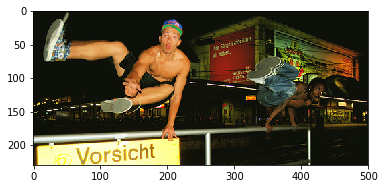

In [35]:
plt.imshow(img);

In [36]:
validation_description['1001545525.jpg']

['Two men in Germany jumping over a rail at the same time without shirts .',
 'Two youths are jumping over a roadside railing , at night .',
 'Boys dancing on poles in the middle of the night .',
 'Two men with no shirts jumping over a rail .',
 'two guys jumping over a gate together']

### 1.1 Text Data (Caption) Cleaning
- No stop word removal
- No stemming
- lower case == upper case
- remove numerical and special character 
- remove punctuation

In [0]:
import re
import collections
import operator

In [0]:
with open('flickr30k/captions/train/training_description.json', 'r') as train:
  training_description = json.load(train)
  
with open('flickr30k/captions/val/validation_description.json', 'r') as val:
  validation_description = json.load(val)

In [0]:
t_archive = training_description
v_archive = validation_description 

In [0]:
def clean_text(sentence):
  
  # convert into lower case
  sentence = sentence.lower()
  
  # remove everything except a-z
  sentence = re.sub("[^a-z]+", " ", sentence)
  
  sentence = sentence.split()
  
  #remove single char words ie: a
  sentence = [word for word in sentence if len(word)>1 ]
  
  sentence = " ".join(sentence)
  
  return sentence
  
  

In [0]:
# clean validation description
for img_name, captions in validation_description.items():
  for i in range(len(captions)):
    captions[i] = clean_text(captions[i])
    

In [42]:
for img_name, captions in validation_description.items():
  print(img_name)
  print(captions)
  break

1000092795.jpg
['two young guys with shaggy hair look at their hands while hanging out in the yard', 'two young white males are outside near many bushes', 'two men in green shirts are standing in yard', 'man in blue shirt standing in garden', 'two friends enjoy time spent together']


In [0]:
# cleaning training description
for img_name, captions in training_description.items():
  for i in range(len(captions)):
    captions[i] = clean_text(captions[i])

In [44]:
for img_name, captions in training_description.items():
  print(img_name)
  print(captions)
  break

126227418.jpg
['man in plaid shirt with laptop in his lap is sitting next to table with microscope and circuit board on it', 'man in plaid shirt connecting his black laptop to his microscope', 'guy with laptop connected to microscope doing some research', 'guy hooking up his laptop to microscope', 'man working on circuit board']


In [0]:
# save the clean text in json file
with open('flickr30k/captions/val/clean_val_desc.json', 'w') as fp:
  json.dump(validation_description, fp)
with open('flickr30k/captions/train/clean_train_desc.json', 'w') as fp:
  json.dump(training_description, fp)

#### 1.1.1 Vocabulary Creation

In [46]:
print(type(training_description))

<class 'dict'>


In [0]:
# unique words
vocab = set()

# total words
total_words = []


# get the unique word from all captions (combined)
for captions in training_description.values():
  for i in range(len(captions)):
    s = captions[i].split()
    [vocab.update(s)]
    for each in s:
      total_words.append(each)
  

In [48]:
print('total words = %d, unique words = %d' %(len(total_words), len(vocab)))

total words = 1638065, unique words = 17897


In [49]:
total_words[:10]

['man', 'in', 'plaid', 'shirt', 'with', 'laptop', 'in', 'his', 'lap', 'is']

In [0]:
# filter words from vocab according to some threshold frequency

counter = collections.Counter(total_words)


In [0]:
word_freq = dict(counter)

In [52]:
len(word_freq)

17897

In [0]:
# sort this dictionary according to frequency
sorted_freq_count = sorted(word_freq.items(), key=operator.itemgetter(1))

In [54]:
type(sorted_freq_count)

list

In [0]:
threshold = 5

In [0]:
sorted_freq_count = [x for x in sorted_freq_count if x[1] > threshold]

In [0]:
words = [x[0] for x in sorted_freq_count]

In [58]:
len(words)

6896

#### 1.1.2 prepare description for training data
#### adding start and snd token to caption
  

In [0]:
training_description = t_archive

In [0]:
for captions in training_description.values():
  for i in range(len(captions)):
    caption = captions[i].split()
    caption.insert(0, 'startseq')
    caption.append('endseq')
    caption = " ".join(caption)
    captions[i] = caption
    #print(caption)
    

In [61]:
len(training_description)

31000

In [62]:
training_description['126227418.jpg']

['startseq man in plaid shirt with laptop in his lap is sitting next to table with microscope and circuit board on it endseq',
 'startseq man in plaid shirt connecting his black laptop to his microscope endseq',
 'startseq guy with laptop connected to microscope doing some research endseq',
 'startseq guy hooking up his laptop to microscope endseq',
 'startseq man working on circuit board endseq']

## 2. Feature  Extraction Models

In [0]:
from keras.models import *
from keras.layers import *

### we will extract the feature from two CNN architecture

### 2.1 Resnet50

In [65]:
resnet50_base = keras.applications.resnet.ResNet50(weights='imagenet', input_shape=(224,224, 3))








102973440/102967424 [==============================] - 8s 0us/step


In [0]:
# resnet50_base.summary()

### 2.2 EfficientNet

In [0]:
# ! pip install keras_efficientnets
import keras_efficientnets

In [70]:
efficientb5_base = keras_efficientnets.EfficientNetB5(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

115302400/115295288 [==============================] - 10s 0us/step


In [0]:
# efficientb5_base.summary()

### 2.3 keras functional API 

#### 2.3.1 ResNet50

In [0]:
resnet = keras.Model(resnet50_base.input, resnet50_base.layers[-2].output)

In [0]:
# resnet.summary()

#### 2.3.2 EfficientNet

In [0]:
global_avg_pooling_layer = GlobalAveragePooling2D(data_format=None)(efficientb5_base.layers[-1].output)

In [0]:
efficient = Model(efficientb5_base.input, outputs = global_avg_pooling_layer)

In [0]:
# efficient.summary()

## 3. Data Preprocessing for Images

In [0]:
import keras.preprocessing.image as  image
from keras.applications.resnet50 import preprocess_input

In [0]:
def image_preprocessing(img):
  img = image.load_img(img, target_size=(224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  
  # Normalization
  img = preprocess_input(img)
  
  #print(img.shape)
  return img

In [0]:
img = image_preprocessing('flickr30k/images/train/126227418.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


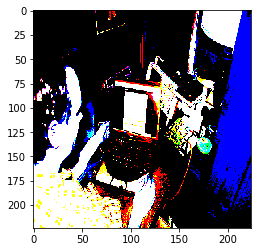

In [80]:
plt.imshow(img[0])

In [0]:
def encode_image(img):
  
  img = image_preprocessing(img)
  
  feature_vector = resnet.predict(img)
  
  #print(feature_vector.shape)
  feature_vector = feature_vector.reshape((-1, ))
  
  return feature_vector

In [82]:
encode_image('flickr30k/images/train/126227418.jpg').shape

(2048,)

### 3.1 Extracting the features for all images

In [0]:
import time
import pickle

In [0]:
list_of_train_images = os.listdir(train_dir)
list_of_val_images = os.listdir(val_dir)

In [85]:
print(len(list_of_train_images))
print(len(list_of_val_images))

31000
783


In [123]:
encoding_train = {}

start = time.time()

for ith in range(len(list_of_train_images)):
  encoding_train[list_of_train_images[ith]] = encode_image(train_dir+list_of_train_images[ith])
  
  if ith%1000 == 0:
    print('encoding progress time step %d'%ith)

end = time.time()
print('time taken = %d'%(end - start))

encoding progress time step 0
encoding progress time step 1000
encoding progress time step 2000
encoding progress time step 3000
encoding progress time step 4000
encoding progress time step 5000
encoding progress time step 6000
encoding progress time step 7000
encoding progress time step 8000
encoding progress time step 9000
encoding progress time step 10000
encoding progress time step 11000
encoding progress time step 12000
encoding progress time step 13000
encoding progress time step 14000
encoding progress time step 15000
encoding progress time step 16000
encoding progress time step 17000
encoding progress time step 18000
encoding progress time step 19000
encoding progress time step 20000
encoding progress time step 21000
encoding progress time step 22000
encoding progress time step 23000
encoding progress time step 24000
encoding progress time step 25000
encoding progress time step 26000
encoding progress time step 27000
encoding progress time step 28000
encoding progress time step

In [124]:
encoding_val = {}

start = time.time()

for ith in range(len(list_of_val_images)):
  encoding_val[list_of_val_images[ith]] = encode_image(val_dir+list_of_val_images[ith])
  
  if ith%100 == 0:
    print('encoding progress time step %d'%ith)

end = time.time()
print('time taken = %d'%(end - start))

encoding progress time step 0
encoding progress time step 100
encoding progress time step 200
encoding progress time step 300
encoding progress time step 400
encoding progress time step 500
encoding progress time step 600
encoding progress time step 700
time taken = 25


### 3.2 store the extracted feature into disk

In [88]:
encoding_train['126227418.jpg'].shape

(2048,)

In [0]:
with open('train_features.pkl', 'wb') as fp:
  pickle.dump(encoding_train, fp)
with open('val_features.pkl', 'wb') as fp:
  pickle.dump(encoding_val, fp)

In [0]:
# clear the dictionary to free the ram we will store from pkl file whenever we need
encoding_train.clear()
encoding_val.clear()

## 4. Text Preprocessing for Captions

In [132]:
len(vocab)

17897

In [92]:
len(words)

6896

In [0]:
word_to_idx = {}
idx_to_word = {}

for i,  word in enumerate(words):
  word_to_idx[word] = (i+1)
  idx_to_word[i+1] = word

In [94]:
idx_to_word[6]

'ohio'

In [0]:
# add two special words (startseq, endseq) into dicitonaries
idx_to_word[6897] = 'endseq'
word_to_idx['endseq'] = 6897

idx_to_word[6898] = 'startseq'
word_to_idx['startseq'] = 6898

In [96]:
len(word_to_idx)

6898

In [0]:
vocab_size = len(word_to_idx)

### 4.1 Find the maximum length description

In [0]:
max_len = 0
img_id = None


for key in training_description.keys():
  for caption in training_description[key]:
    if len(caption) > max_len:
      max_len = len(caption)
      img_id = key

In [99]:
max_len

402

In [100]:
len(training_description[img_id][0])

402

In [101]:
img_id

'207344485.jpg'

In [0]:
img = cv2.imread('flickr30k/images/train/207344485.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

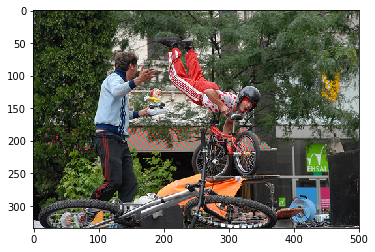

In [103]:
plt.imshow(img)

#### Saving the processed data into local directory

In [0]:
# !zip -r flickr30k.zip flickr30k

In [120]:
encoding_val

{}

### 4.2 Data Loader Generator

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


In [131]:
vocab_size

6898

In [0]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []
    n=0
    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

### 4.3 Word Embeddings

In [135]:
!unzip drive/My\ Drive/glove.6B

Archive:  drive/My Drive/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
f = open('glove.6B.50d.txt')

In [0]:
embedding_idx = {}

In [0]:
for line in f:
  values = line.split()
  
  word = values[0]
  
  embedding = np.array(values[1:], dtype='float')
  
  embedding_idx[word] = embedding

In [140]:
embedding_idx['hello'].shape

(50,)

In [0]:
f.close()

In [0]:
def get_embedding_matrix():
  
  emb_dim = 50
  matrix = np.zeros((vocab_size, emb_dim))
  
  for word, idx in word_to_idx.items():
    
    embedding = embedding_idx.get(word)
    
    if embedding is not None:
      matrix[idx] = embedding
     
   
    return matrix
    
    

In [0]:
embedding_matrix = get_embedding_matrix()

In [148]:
embedding_matrix.shape

(6898, 50)

In [151]:
embedding_matrix[6897]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 5. Model Architecture

In [0]:
from keras.layers import *
from keras.optimizers import *

In [0]:
# # image feature extractor model
# input_img_fea = Input(shape=(2048,))
# inp_img1 = Dropout(0.3)(input_img_fea)
# inp_img2 = Dense(256, activation='relu')(inp_img1)



In [0]:
# # partial caption sequence model
# input_cap = Input(shape=(max_len,))
# inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
# inp_cap2 = Dropout(0.3)(inp_cap1)
# inp_cap3 = LSTM(256)(inp_cap2)

In [0]:
# decoder1 = add([inp_img2 , inp_cap3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # Merge 2 networks
# model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [0]:
def model_architecture(vocab_size, feature_shape=(2048, ),emb_dim=50):
  
  # image model -> image feature as input
  input_img_features = Input(shape=(2048, ))
  input_img1 = Dropout(0.3)(input_img_features)
  input_img2 = Dense(256, activation='relu')(input_img1)
  
  #text model -> captions as input
  input_captions = Input(shape=(max_len, ))
  input_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
  input_cap2 = Dropout(0.3)(input_cap1)
  input_cap3 = LSTM(256)(input_cap2)
  
  # combined model to predict the prob fo the next word in the sequence
  decoder1 = add([input_img2, input_cap3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  decoder3 = Dense(vocab_size, activation='softmax')(decoder2)
  
  
  model = Model(inputs=[input_img_features, input_captions], outputs=decoder3)
  
  return model
  
  

In [0]:
model = model_architecture(vocab_size)

In [172]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 402)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 402, 50)      344900      input_14[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 2048)         0           input_13[0][0]                   
____________________________________________________________________________________________

In [0]:
model.layers[2].set_weights= embedding_matrix
model.layers[2].trainable = False

In [176]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## 6. Training the Model

In [0]:
epochs = 20
batch_size = 4

In [0]:
steps = len(training_description)//batch_size

In [180]:
len(training_description)

31000

In [0]:
def train():
  
  for epoch in range(epochs):
    generator = data_generator(training_description, encoding_train, word_to_idx, max_len, batch_size)
    
    model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose=1)
    
    # save the  weights
    model.save_weights('model_weights/'+str(epoch)+".h5")
#     print(generator)
#     break

In [0]:
train()

Epoch 1/1
2294/7750 [=======>......................] - ETA: 1:51:22 - loss: 5.3879

In [0]:
data_generator()